# Vehicle detection

In [23]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import sys
import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


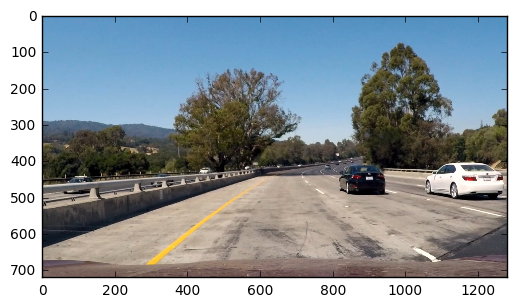

In [24]:
list_images = glob.glob('test_images/*')
list_images = sorted(list_images)
print(list_images)
img_test = cv2.imread(list_images[0])
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)

In [25]:
# functions to use in main code
''' ---from udacity lessons--- '''

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else:
        return img 
    
    

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# modifed function to return the boxes and the image and accept threshold for svm predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, my_th=2.8):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    list_boxes = []
    feat_ = []
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            
            hist_features = color_hist(subimg, nbins=hist_bins)

            # modified to only get two kind of features
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.decision_function(test_features)
            #print(test_prediction)
            
            if test_prediction > my_th:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_ = ((xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw+ystart))
                list_boxes.append(box_)
    return draw_img, list_boxes


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# function to get a set of features and put them into a list
def extract_features_set(list_images_set, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    data_features = []
    for each_path in list_images_set:
        img = cv2.imread(each_path)
        data_features.append(single_img_features(img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat))
    return data_features
'''--- ---'''


# function to prepare dataset, it returns the features and the labels
def get_data(vehicle_path, non_vehicle_path, take_pos = 0, take_neg = 0):
    x_data = []
    y_data = []
    x_data_car = []
    y_data_car = []
    x_data_nocar = []
    y_data_nocar = []
    im_v = glob.glob(vehicle_path + '/*')
    list_path_images = []
    for each_folder in im_v:
        im_list = glob.glob(each_folder + '/*')
        list_path_images = list_path_images + list(im_list)
        
    for each_path in list_path_images:
        #img = cv2.imread(each_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img_feature = single_img_features(img)
        #x_data_car.append(img_feature)
        x_data_car.append(each_path)
        y_data_car.append(1)
    
    im_nv = glob.glob(non_vehicle_path + '/*')
    list_path_images = []
    for each_folder in im_nv:
        im_list = glob.glob(each_folder + '/*')
        list_path_images = list_path_images + list(im_list)
    for each_path in list_path_images:
        #img = cv2.imread(each_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img_feature = single_img_features(img)
        #x_data_nocar.append(img_feature)
        x_data_nocar.append(each_path)
        y_data_nocar.append(0)

        
    
    if take_pos != 0:
        random.shuffle(x_data_car)
        
        x_data = x_data_car[:int(take_pos)] 
        y_data = y_data_car[:int(take_pos)] 
        
    else:
        x_data = x_data_car
        y_data = y_data_car
        
    print 'positive', len(x_data)
    
    if take_neg != 0:
        random.shuffle(x_data_nocar)
        x_data = x_data + x_data_nocar[:int(take_neg)]
        y_data = y_data + y_data_nocar[:int(take_neg)]
    else:
        x_data = x_data + x_data_nocar
        y_data = y_data + y_data_no_car
        
    print 'positive + negative', len(x_data)
    
    return x_data, y_data

In [38]:
# get path images
my_x, my_y = get_data('vehicles/', 'non-vehicles/', take_pos=600, take_neg=4400)

positive 600
positive + negative 4668


In [39]:
# extract_features from list of images and these parameters

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
data_feats = extract_features_set(my_x, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

In [40]:
# Normalize data
X_scaler = RobustScaler().fit(data_feats)
scaled_X = X_scaler.transform(data_feats)
print("shape information x", scaled_X.shape)
print("shape information y", len(my_y))

('shape information x', (4668, 8460))
('shape information y', 4668)


In [41]:
# split data
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, my_y, test_size=0.2, random_state=rand_state)

In [42]:
k=5
svc = LinearSVC(C=10**k)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

(17.82, 'Seconds to train SVC...')


In [43]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

('Test Accuracy of SVC = ', 0.9936)


## Test pipeline detection

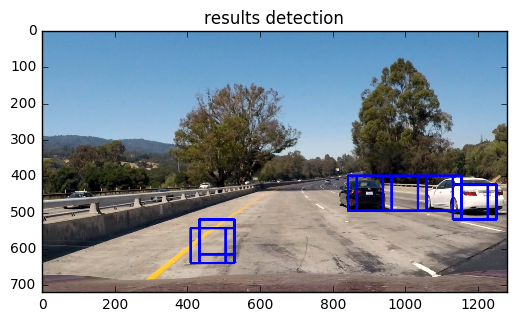

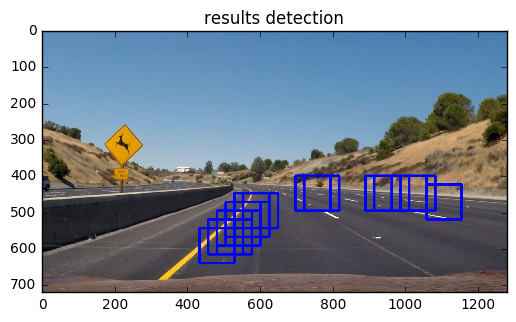

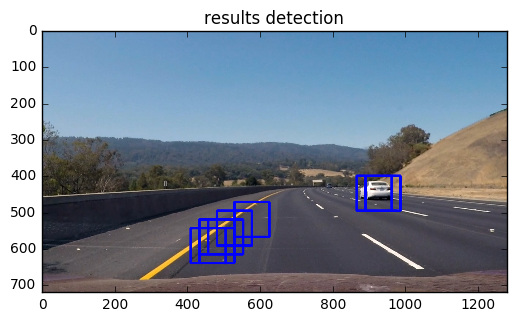

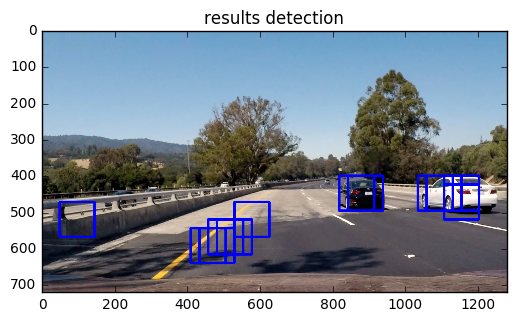

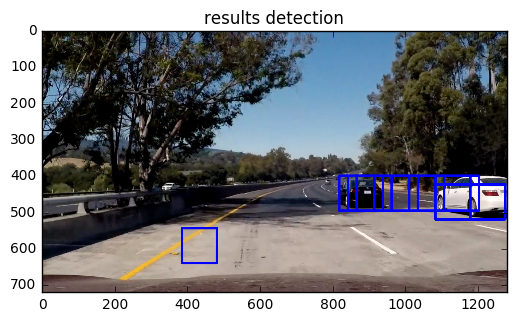

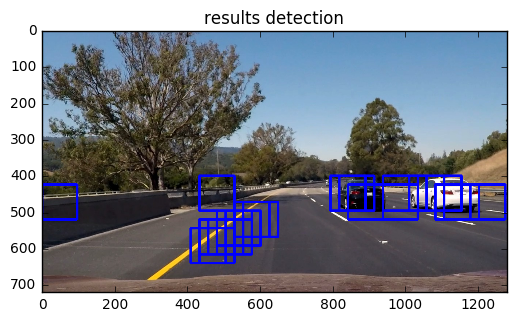

In [44]:
ystart = 400
ystop = 656
scale = 1.4

y_start_stop = [ystart, ystop]

for k in range(6):
    path_test = list_images[k]
    img_test = cv2.imread(path_test)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    draw_image = np.copy(img_test)
    
    windows = slide_window(img_test, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img_test, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
 

    out_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    plt.figure()
    plt.title('results detection')
    plt.imshow(out_img)

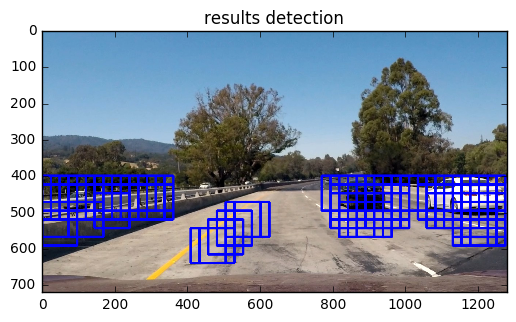

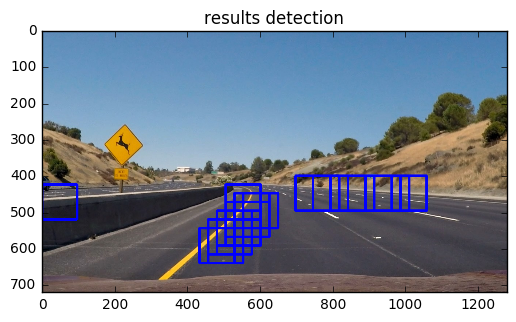

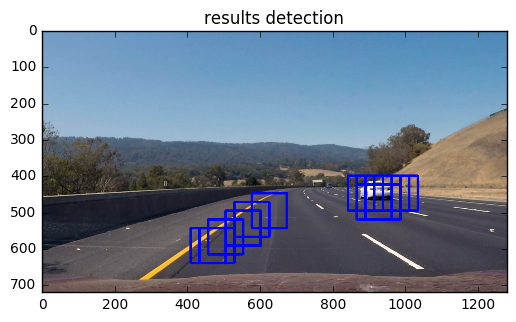

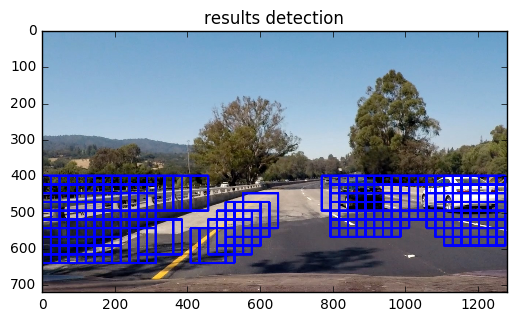

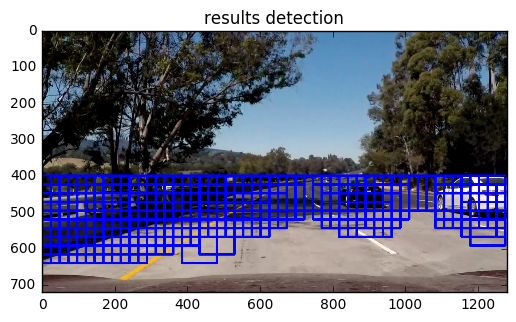

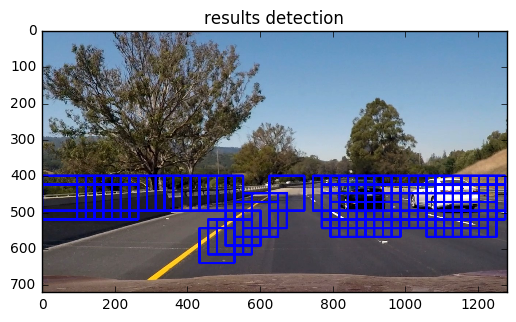

In [32]:
ystart = 400
ystop = 656
scale = 1.4

y_start_stop = [ystart, ystop]

for k in range(6):
    path_test = list_images[k]
    img_test = cv2.imread(path_test)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    draw_image = np.copy(img_test)
    
    windows = slide_window(img_test, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img_test, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
 

    out_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    plt.figure()
    plt.title('results detection')
    plt.imshow(out_img)

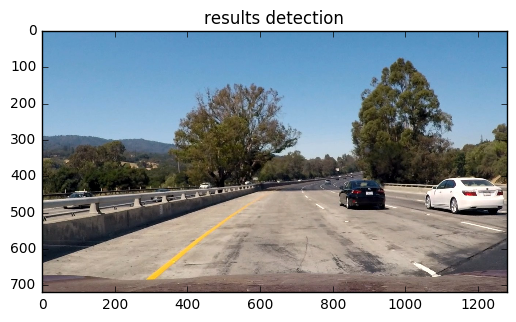

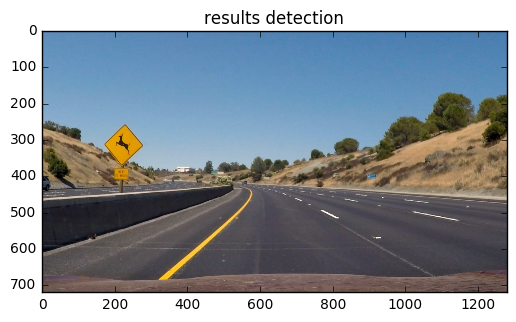

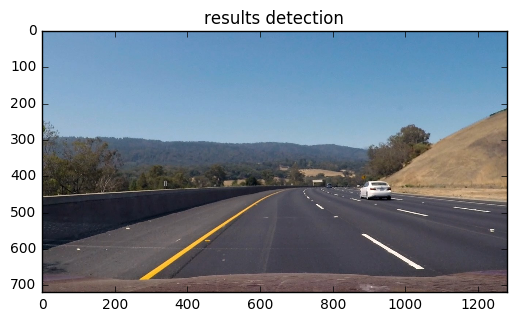

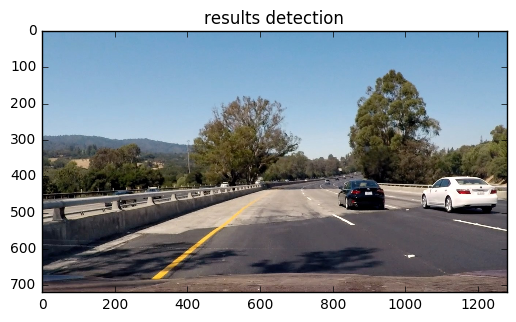

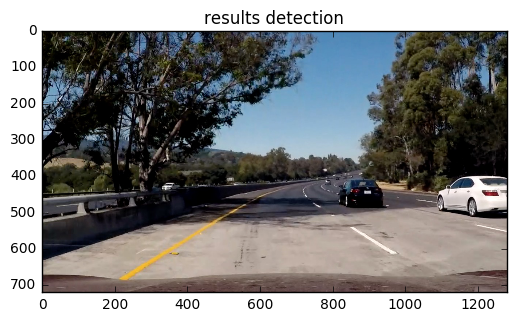

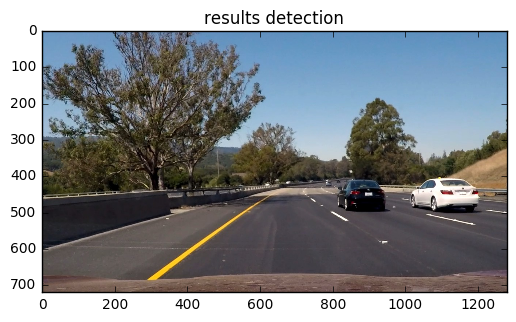

In [33]:
ystart = 400
ystop = 656
scale = 1.4

y_start_stop = [ystart, ystop]

for k in range(6):
    path_test = list_images[k]
    img_test = cv2.imread(path_test)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.title('results detection')
    plt.imshow(img_test)

# save current model

In [45]:
import pickle

In [46]:
with open('model.pickle', 'wb') as output:
    pickle.dump(svc, output, pickle.HIGHEST_PROTOCOL)
    
with open('scaler.pickle', 'wb') as output:
    pickle.dump(X_scaler, output, pickle.HIGHEST_PROTOCOL)


# load the model

In [ ]:
with open('find_car_model_6000.pkl', 'rb') as in_path:
    the_svc = pickle.load(in_path)

# Final detection

In [ ]:
for path_test in list_images:
    img_test = cv2.imread(path_test)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    draw_image = np.copy(img_test)
    '''
    windows = slide_window(img_test, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img_test, windows, the_svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    '''
    ystart = 400
    ystop =500
    scale = 1.2
    _ , hot_windows1 = find_cars(img_test, ystart, ystop, scale, list_svm[5], X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 1.6)
    
    ystart = 400
    ystop =656
    scale = 1.5
    _ , hot_windows2 = find_cars(img_test, ystart, ystop, scale, list_svm[5], X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 1.6)
    hot_windows = hot_windows1 + hot_windows2

    out_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(img_test), labels)
    '''
    plt.figure()
    plt.title('results detection')
    plt.imshow(out_img)
    plt.figure()
    plt.title('heatmap')
    plt.imshow(heatmap,cmap='hot')
    '''

# Temporal and spatial filter

In [ ]:
def flat_list(total_wd):
    return [item for sublist in total_wd for item in sublist]

In [ ]:
temporal_list_images = glob.glob('test_images/frame*')
temporal_list_images = sorted(temporal_list_images)
total_windows = []
count = 1
first_5_frames = False
num_reference = 3

for k in range(6):
    img_test = cv2.imread(temporal_list_images[k])
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    draw_image = np.copy(img_test)
    windows = slide_window(img_test, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img_test, windows, the_svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
  
    

    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    
    plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('detections')
    ax1.imshow(out_img_pure)
    ax2.set_title('heatmap')
    ax2.imshow(heatmap, cmap='hot')
    
    
    print("counting", count)
    if (count % num_reference) == 0:
        count = 1
        first_5_frames = True
    if first_5_frames:
        print("update in boxes")
        del total_windows[0]
    count += 1
    
    boxes = flat_list(hot_windows)
    heat = np.zeros_like(img_test[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    out_img = draw_labeled_bboxes(np.copy(img_test), labels)
    plt.figure()
    plt.imshow(out_img)


# Create video

In [ ]:
total_windows = []
count = 1
first_5_frames = False
num_reference = 3

def process_frame(input_image):
    global count, first_5_frames, total_windows
    draw_image = np.copy(input_image)
    '''
    windows = slide_window(input_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(input_image, windows, the_svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    '''
    ystart = 400
    ystop =500
    scale = 1.2
    _ , hot_windows1 = find_cars(input_image, ystart, ystop, scale, list_svm[5], X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, -8.8)
    
    ystart = 400
    ystop =656
    scale = 1.5
    _ , hot_windows2 = find_cars(input_image, ystart, ystop, scale, list_svm[5], X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, -8.8)
    hot_windows = hot_windows1 + hot_windows2

    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    total_windows.append(hot_windows)
    #print("counting", count)
    if (count % 3) == 0:
        count = 1
        first_5_frames = True
    if first_5_frames:
        #print("update in boxes")
        del total_windows[0]
    count += 1
    
    boxes = flat_list(total_windows)
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(input_image), labels)

    return out_img

In [ ]:
project_output = "yy_.mp4"
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_output, audio=False)
#white_clip.write_videofile(project_output, audio=False)

In [ ]:
new_clip_output = 'out_project_.mp4'
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

In [ ]:
print(X_scaler)

In [ ]:
from subprocess import call
print(call(['ls']))